In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from typing import List
import json
from statistics import mean
import random
random.seed(42)

rootpath = ".."

degree_sign = u'\N{DEGREE SIGN}'

In [51]:
result_filename = f"{rootpath}/results/result_data/transfer_results.json"

with open(result_filename, "r") as f:
    results_data = json.load(f)

ft_percents = results_data["options"]["ft_percents"]
shuffle_seeds = results_data["options"]["seeds"]
transfer_methods = ["weight_initialization_LSTMDense", "weight_initialization_AutoLSTM"]

In [52]:
# Create a subplots figure with two subplots and set title
x = [fp * 100 for fp in ft_percents]

# initialize the dataframe for pir values
keys = [building+tower+"_"+season for building in ["ESB", "Kissam"] for tower in ["1","2"] for season in ["summer", "fall"]]
pir_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
pir_df['index'] = keys
pir_df.set_index("index", inplace=True)

mae_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
mae_df['index'] = keys
mae_df.set_index("index", inplace=True)

def calcPir(base_error, transfer_error):
    if base_error == 0: raise ValueError("Base error is 0")
    return (base_error - transfer_error) / base_error

tm = transfer_methods[1]

for from_key in keys:
    for to_key in keys:

        if to_key == from_key: pir_df.loc[to_key, from_key] = 0
        try:
            base_mae = results_data[tm][to_key]["base"]["mae"]

            # # AVERAGE MAE METHOD
            avgm = [0.0] * len(ft_percents)
            
            for i, ft in enumerate([f"ft{int(fp * 100)}" for fp in ft_percents]):
                print(tm, from_key, to_key, ft, base_mae)
                print(results_data[tm][from_key][to_key][ft]["mae"])
                if None in results_data[tm][from_key][to_key][ft]["mae"]: raise ValueError("Skip this graph")
                avgm[i] = mean(results_data[tm][from_key][to_key][ft]["mae"])
            
            pir_list = [calcPir(base_mae, x) for x in avgm]
            pir_df.loc[to_key, from_key] = max(pir_list)
            mae_df.loc[to_key, from_key] = min(avgm)
            

            # # LOWEST MAE METHOD
            # min_mae_list = [0.0] * len(ft_percents)
            # for i, ft in enumerate([f"ft{int(fp * 100)}" for fp in ft_percents]):
            #     if None in results_data[tm][from_key][to_key][ft]["mae"]: raise ValueError("Skip this graph")
            #     min_mae_list[i] = min(results_data[tm][from_key][to_key][ft]["mae"])
            # pir_list = [calcPir(base_mae, x) for x in min_mae_list]
            # pir_df.loc[to_key, from_key] = max(pir_list)
            
        except: continue # in case of null values (transfers that have not been run yet)

weight_initialization_AutoLSTM ESB1_summer ESB1_summer ft0 7.92050981848776
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft0 6.064622373322284
[59.62255555626102, 59.62255555626102, 59.62255555626102, 59.62255555626102, 59.62255555626102]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft20 6.064622373322284
[10.939267849743938, 12.036068575068162, 10.905291648109497, 10.688795196286334, 10.616143626931771]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft40 6.064622373322284
[8.341078858451692, 8.244754368168993, 8.309919934106656, 8.255297992167607, 8.387741451559364]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft60 6.064622373322284
[7.733197847362004, 7.581676797107812, 7.77297344351444, 7.632790024233494, 7.808089830023765]
weight_initialization_AutoLSTM ESB1_summer ESB1_fall ft80 6.064622373322284
[7.6877075527413705, 7.222959778685721, 7.445699226881695, 7.458007392631004, 7.559281932886978]
weight_initialization_AutoLSTM ESB1_summer ESB2_summer ft0 7

In [53]:
pd.set_option("display.precision", 3)
print(mae_df)

               ESB1_summer ESB1_fall ESB2_summer ESB2_fall Kissam1_summer  \
index                                                                       
ESB1_summer           None     8.415       8.035     8.487          8.056   
ESB1_fall            7.475      None       6.857     6.048          6.626   
ESB2_summer          7.152     7.394        None     7.564          7.349   
ESB2_fall            8.851     7.534       8.463      None          8.059   
Kissam1_summer       9.771     9.294       9.565     9.473           None   
Kissam1_fall         7.543     5.958        6.45     6.185          5.571   
Kissam2_summer      10.033     9.607       9.933     9.875          8.966   
Kissam2_fall         7.792     6.608       7.211     6.984          6.296   

               Kissam1_fall Kissam2_summer Kissam2_fall  
index                                                    
ESB1_summer           8.432          8.523        8.224  
ESB1_fall             6.627          6.751        6.443

<Axes: ylabel='index'>

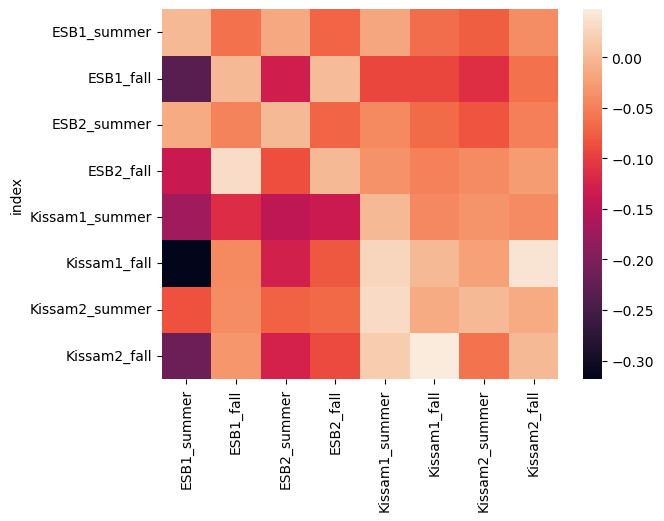

In [54]:
pir_df = pir_df.astype(float)
sns.heatmap(pir_df)

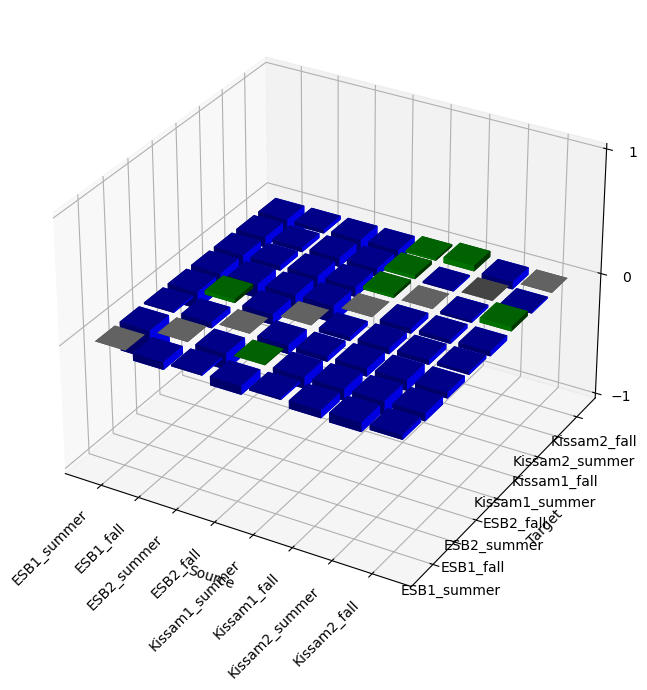

In [55]:
df = pir_df
index_labels = keys

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Create numeric indices for x and y axes
x_indices = np.arange(len(keys))
y_indices = np.arange(len(df.columns))

# Create 2D meshgrid
x, y = np.meshgrid(x_indices, y_indices)

# Flatten indices and values
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = df.values.flatten()

# Color all bars with positive z values in green
colors = ['green' if val > 0 else 'grey' if val == 0 else 'blue' for val in z_flat]

# Create 3D bar plot with adjusted alpha 
ax.bar3d(x_flat, y_flat, np.zeros_like(z_flat), 0.8, 0.8, z_flat, shade=True, color=colors)

# Set axis labels
ax.set_xlabel('Source')
ax.set_ylabel('Target')
ax.set_zlabel('Values')

# Set tick labels
ax.set_xticks(x_indices + 0.4)
ax.set_xticklabels(keys)
ax.set_yticks(y_indices + 0.4)
ax.set_yticklabels(df.columns)
ax.set_zticks(range(-1, 2))

# Rotate the x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Display the plot
plt.show()


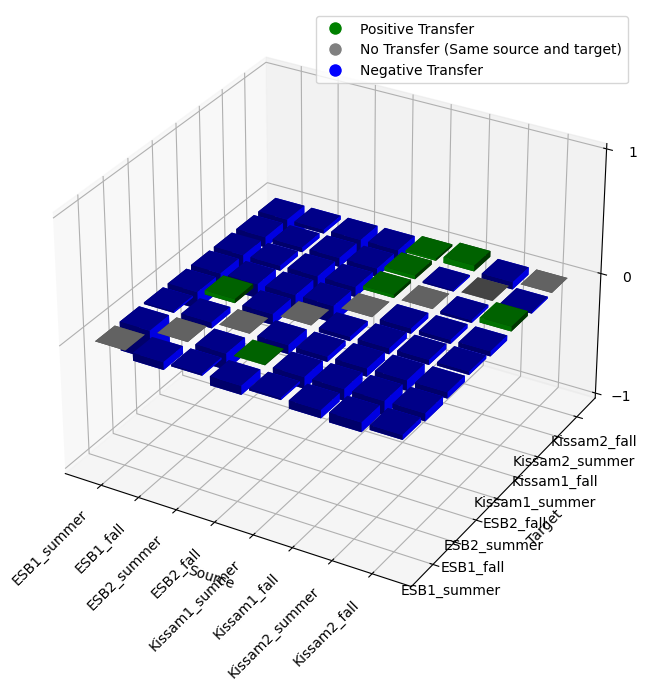

In [56]:


# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Create numeric indices for x and y axes
x_indices = np.arange(len(keys))
y_indices = np.arange(len(df.columns))

# Create 2D meshgrid
x, y = np.meshgrid(x_indices, y_indices)

# Flatten indices and values
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = df.values.flatten()

# Color all bars with positive z values in green
colors = ['green' if val > 0 else 'grey' if val == 0 else 'blue' for val in z_flat]

# Create 3D bar plot with adjusted alpha 
bars = ax.bar3d(x_flat, y_flat, np.zeros_like(z_flat), 0.8, 0.8, z_flat, shade=True, color=colors)

# Set axis labels
ax.set_xlabel('Source')
ax.set_ylabel('Target')
ax.set_zlabel('Values')

# Set tick labels
ax.set_xticks(x_indices + 0.4)
ax.set_xticklabels(keys)
ax.set_yticks(y_indices + 0.4)
ax.set_yticklabels(df.columns)
ax.set_zticks(range(-1, 2))

# Rotate the x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Create legend
legend_labels = ['Positive Transfer', 'No Transfer (Same source and target)', 'Negative Transfer']
legend_colors = ['green', 'grey', 'blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
ax.legend(legend_handles, legend_labels, loc='upper right')

# Display the plot
plt.show()


In [57]:
# Create 3D bar plot using Plotly
fig = go.Figure()

# Add surface plot
fig.add_trace(go.Surface(
    z=df.values,
    x=df.columns,
    y=index_labels,
    colorscale='Viridis',  # choose a colorscale
    colorbar=dict(title='Values'),
))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Source'),
        yaxis=dict(title='Target'),
        zaxis=dict(title='PIR'),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Show the plot
fig.show()